## STA141B Final Project
### Name: Lijing Xu

In [58]:
import sys
#!{sys.executable} -m pip install scrapy
#!{sys.executable} -m pip install wordcloud
#!{sys.executable} -m pip install requests_cache
#!{sys.executable} -m pip install html2text
#!{sys.executable} -m pip install folium
#!{sys.executable} -m pip install plotly

### Introduction ###

In [54]:
from bs4 import BeautifulSoup
from itertools import chain
import matplotlib
from collections import Counter
from nltk.corpus import stopwords
import urllib
from lxml import html
import numpy as np
import requests
import pandas as pd
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from matplotlib import pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import requests_cache
requests_cache.install_cache('demo_cache')
import math
from matplotlib import pyplot
import statsmodels
from scipy.interpolate import interp1d
import warnings
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import html2text
#import urllib2
import re
import folium
import plotly.graph_objs as go
warnings.filterwarnings("ignore")
from IPython.display import HTML
matplotlib.style.use('ggplot')

This project is used to fulfil part of the requirement of the class. The dataset is the car posts from craiglist. We want to analyze the information provided in the post. There are 34677 observations and 25 variables in the dataset. We only select some variables to analyze. The details are given below. 

Let's first read the dataset

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sqlalchemy as sqla
import sqlite3
%matplotlib inline
plt.style.use('ggplot')

First, let's read the vehicle data. Since the files are so large, we can't upload them all in one csv because of the limitation on Github. Instead, we split the datasets into three csv. Then, we are going to read them one by one. Then, we will use pandas.concat to combine them all in one dataframe. 

In [4]:
vehicle1 = pd.read_csv('vehicle1.csv')
vehicle2 = pd.read_csv('vehicle2.csv')
vehicle3 = pd.read_csv('vehicle3.csv')

Combine them into one giant dataframe. 

In [5]:
vehicle = pd.concat([vehicle1, vehicle2, vehicle3], ignore_index=True)

The dimension of the dataset is given below. We have 34677 observations with 26 variables. 

In [6]:
vehicle.shape

(34677, 26)

The first 5 observations are given below. 

In [7]:
vehicle.head()

id                                              title  \
0  5228397709  2012 Chevrolet Camaro SS - All Credit Accepted...   
1  5228437424  2013 Chevrolet Equinox LT - All Credit Accepte...   
2  5228475701  2013 Nissan Altima 2.5 SV - All Credit Accepte...   
3  5228506948  2009 Infiniti M35x X - All Credit Accepted - $...   
4  5228535298  2013 Infiniti G37x X - All Credit Accepted - $...   

                                                body        lat       long  \
0  2012 Chevrolet Camaro SS\nOffered by: Automax ...  42.299098 -71.446701   
1  2013 Chevrolet Equinox LT\nOffered by: Automax...  42.299098 -71.446701   
2  2013 Nissan Altima 2.5 SV\nOffered by: Automax...  42.299098 -71.446701   
3  2009 Infiniti M35x X\nOffered by: Automax Preo...  42.299098 -71.446701   
4  2013 Infiniti G37x X\nOffered by: Automax Preo...  42.299098 -71.446701   

                posted updated drive  odometer   type     ...     byOwner  \
0  2015-09-18 15:50:15     NaN   rwd   16324.0  coupe     ...       False   
1  2015-09-18 16:19:48     NaN   NaN   61095.0    SUV     ...       False   
2  2015-09-18 16:49:38     NaN   fwd   40880.0  sedan     ...       False   
3  2015-09-18 17:15:10     NaN   NaN   76108.0  sedan     ...       False   
4  2015-09-18 17:39:43     NaN   NaN   14942.0  sedan     ...       False   

     city                 time  \
0  boston  2015-09-18 18:50:00   
1  boston  2015-09-18 19:19:00   
2  boston  2015-09-18 19:49:00   
3  boston  2015-09-18 20:14:00   
4  boston  2015-09-18 20:39:00   

                                       description  \
0   2012 Chevrolet Camaro SS - All Credit Accepted   
1  2013 Chevrolet Equinox LT - All Credit Accepted   
2  2013 Nissan Altima 2.5 SV - All Credit Accepted   
3       2009 Infiniti M35x X - All Credit Accepted   
4       2013 Infiniti G37x X - All Credit Accepted   

                                        location                       url  \
0    (Automax Preowned of Framingham)   pic map   /bmw/ctd/5228397709.html   
1    (Automax Preowned of Framingham)   pic map   /bmw/ctd/5228437424.html   
2    (Automax Preowned of Framingham)   pic map   /bmw/ctd/5228475701.html   
3    (Automax Preowned of Framingham)   pic map   /bmw/ctd/5228506948.html   
4    (Automax Preowned of Framingham)   pic map   /bmw/ctd/5228535298.html   

     price  year      maker makerMethod  
0  29896.0  2012  chevrolet         1.5  
1  18797.0  2013  chevrolet         1.5  
2  15792.0  2013     nissan         1.5  
3  18288.0  2009   infiniti         1.5  
4  26389.0  2013   infiniti         1.5  

[5 rows x 26 columns]

Since the dataset is huge and it takes longer time to do subset and plot. Instead, we output it as a database object (sqlite) and then use SQL to do subset. It is faster to subset with SQL query. The codes below show how to convert it from CSV to SQLITE object. 

In [8]:
import csv, sqlite3

con = sqlite3.connect("vehicle.sqlite")
con.text_factory = str
cur = con.cursor()
cur.execute("CREATE TABLE vehicle (id, title, body, lat, long, posted, updated, drive, odometer, type, header, condition, cylinders, fuel, size, transmission, byOwner, city, time, description, location, url, price, year, maker, makerMethod);") # use your column names here

with open('vehicle1.csv','rb') as fin: # `with` statement available in 2.5+
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db = [(i['id'], i['title'], i['body'], i['lat'], i['long'], i['posted'], i['updated'], i['drive'], i['odometer'], i['type'], i['header'], i['condition'], i['cylinders'], i['fuel'], i['size'], i['transmission'], i['byOwner'], i['city'], i['time'], i['description'], i['location'], i['url'], i['price'], i['year'], i['maker'], i['makerMethod']) for i in dr]

cur.executemany("INSERT INTO vehicle (id, title, body, lat, long, posted, updated, drive, odometer, type, header, condition, cylinders, fuel, size, transmission, byOwner, city, time, description, location, url, price, year, maker, makerMethod) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);", to_db)
con.commit()
con.close()

Now, we can start to do some interesting exploration of the dataset. First, let's create the connection to the SQL file

In [9]:
# Create the connection to the SQL file
sqlite_file = "./vehicle.sqlite"
conn = sqla.create_engine('sqlite:///' + sqlite_file)

*** What are the most common cars for sale by owner and by dealer? ***

In [10]:
sql_query = """
SELECT byOwner, count(*) as count
FROM vehicle
group by byOwner;
"""
selected_table = pd.read_sql_query(sql_query,conn)
selected_table.head(n=5)

byOwner  count
0   FALSE   6697
1    TRUE   4862

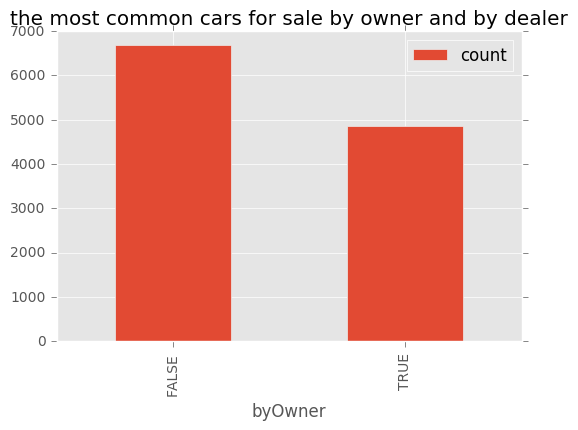

In [11]:
selected_table.plot.bar(x=selected_table['byOwner'], title="the most common cars for sale by owner and by dealer")

For the column byOwner, TRUE means the post is made by owner. FALSE means the post is made by dealer. We can see there are 4862 posts are from owners and 6697 posts are from dealers. 

*** What are average car age sell in each city? ***

Let's first take a look the distribution of the overall car age. 

In [5]:
sql_query = """
SELECT 2017-year as age
FROM vehicle;
"""
selected_table = pd.read_sql_query(sql_query,conn)

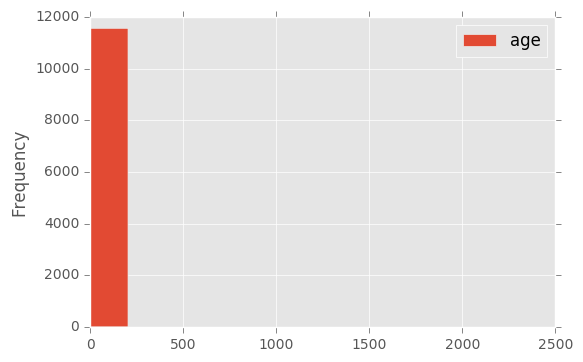

In [14]:
selected_table.plot.hist()

As we can see, we can't see the shape of the distribution in the histogram, a reason is because some car ages calculated are very large. Let's explore that part. The top 5 car ages are listed below. 

In [25]:
sql_query = """
SELECT 2017-year as age
FROM vehicle
order by age desc;
"""
selected_table = pd.read_sql_query(sql_query,conn)
selected_table.head()

age
0  2013
1    87
2    87
3    86
4    83

There is a car age 2013, no wonder we see the range of age is that huge. Now, let's subset it again and remove this number from the data before we plot the histogram. 

In [36]:
sql_query = """
SELECT 2017-year as age
FROM vehicle
where age < 100;
"""
selected_table = pd.read_sql_query(sql_query,conn)

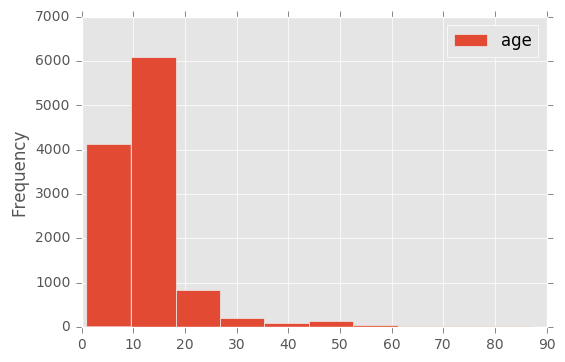

In [37]:
selected_table.plot.hist()

After we remove the outlier, we can see that the distribution of car age is skewed to right. Next, we want to see the average car age sold in each city

In [509]:
sql_query = """
SELECT city, avg(2017-year) as avg_age
FROM vehicle
group by city
having avg_age < 100;
"""
selected_table = pd.read_sql_query(sql_query,conn)

In [48]:
selected_table

city    avg_age
0   boston  12.472771
1  chicago  14.028244
2   denver   9.213411

As we can see, the average car ages is the highest in Chicago. The lowest average car ages is in Denver.

*** What are distribution of car age different between the posts by seller and owner? ***

In [143]:
sql_query = """
SELECT 2017-year as age
FROM vehicle
where age < 1000 and byOwner='FALSE';
"""
x = pd.read_sql_query(sql_query,conn)
x = x.as_matrix()

In [144]:
sql_query = """
SELECT 2017-year as age
FROM vehicle
where age < 1000 and byOwner='TRUE';
"""
y = pd.read_sql_query(sql_query,conn)
y = y.as_matrix()

Below histogram show the distribution of car ages for sell by owner and by dealer. 

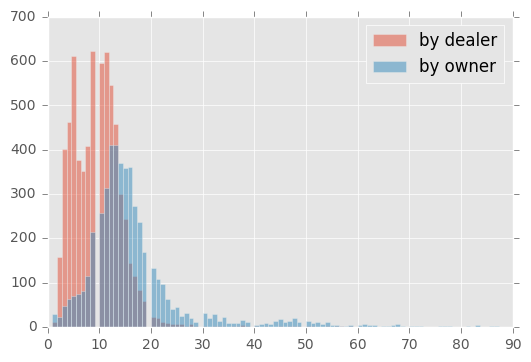

In [147]:
#x = [random.gauss(3,1) for _ in range(400)]
#y = [random.gauss(4,2) for _ in range(400)]

bins = np.linspace(0, 90, 100)

plt.hist(x, bins, alpha=0.5, label='by dealer')
plt.hist(y, bins, alpha=0.5, label='by owner')
plt.legend(loc='upper right')
plt.show()

As we can see, the car sell by onwer are in general older than the car sell by dealer. It makes sense because dealer used to keep young car so they can sell it easily. 

*** Explore the relationship between odometer and age of car ***

In [236]:
sql_query = """
SELECT odometer, 2017-year as age
FROM vehicle
where age < 100 and odometer != 'NA';
"""
selected_table = pd.read_sql_query(sql_query,conn)
selected_table.head(n=5)

odometer  age
0    16324    5
1    61095    4
2    40880    4
3    76108    8
4    14942    4

In [261]:
odometer = selected_table.odometer.astype(str).astype(int).astype(float)
age = selected_table.age

The missin values are removed from odometers. Histogram of odometers is given below. 

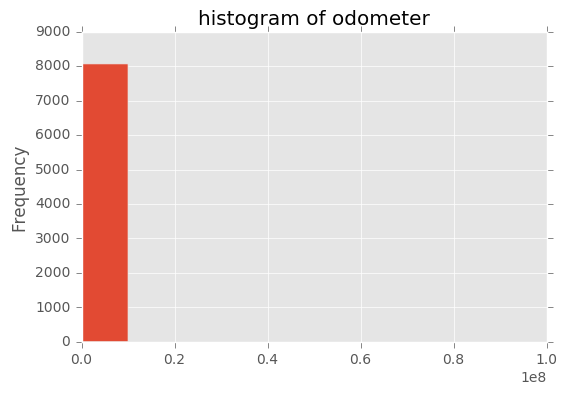

In [264]:
odometer.plot.hist(title='histogram of odometer')

As we can see, it is hard to see the distribution of odometer. It seems that we have an outlier. Let's check the possible outliers. 

In [266]:
sql_query = """
SELECT odometer, 2017-year as age
FROM vehicle
where age < 100 and odometer != 'NA'
order by odometer desc;
"""
selected_table = pd.read_sql_query(sql_query,conn)
selected_table.head(n=5)

odometer  age
0  99999999   29
1     99989   10
2     99985    7
3     99914   10
4     99912   10

So, there is an odometer with value 99999999. We should remove them from the dataset. 

In [435]:
sql_query = """
SELECT odometer, 2017-year as age, price
FROM vehicle
where age < 50 and odometer != 'NA' and odometer != '99999999' and price != 'NA';
"""
selected_table = pd.read_sql_query(sql_query,conn)
selected_table.head(n=5)

odometer  age  price
0    16324    5  29896
1    61095    4  18797
2    40880    4  15792
3    76108    8  18288
4    14942    4  26389

Since the data type of the odometer is object. We need to first covert it to string, and then convert it to integer before we can make the scatterplot. 

In [458]:
odometer = selected_table.odometer.astype(str).astype(int)
age = selected_table.age
price = selected_table.price.astype(float)

In [461]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)
def stddev(lst):
    """calculates standard deviation"""
    sum = 0
    mn = mean(lst)
    for i in range(len(lst)):
        sum += pow((lst[i]-mn),2)
    return (sum/len(lst)-1)**(1/2)

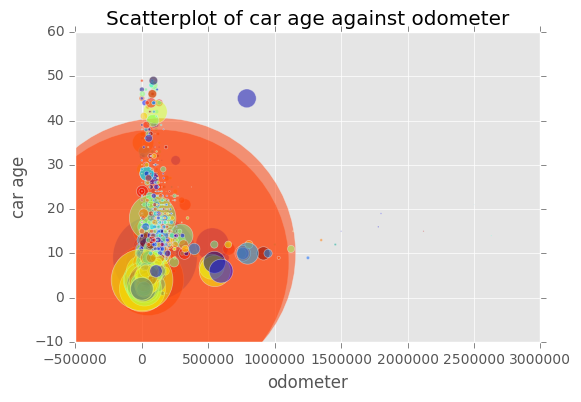

In [474]:
fig, ax = plt.subplots()

N = len(age)
x = odometer
y = age
colors = np.random.rand(N)
area = np.pi * (15000 * (price.astype(float))/sum(price.astype(float)))**2  # 0 to 15 point radii

ax.scatter(x, y, s=area, c=colors, alpha=0.5)

ax.set_xlabel('odometer')
ax.set_ylabel('car age')
ax.set_title('Scatterplot of car age against odometer')

plt.show()

The scatterplot of car age against odometer is given above. The size of the circle is proportional to the car's sell price. We can see only few odometer are very large. But most of them are below 300000. Also, few cars sell for a very huge amount since few cirles are much larger compared to the rest. 

*** Where are the posts made? visualize it on the map ***

In [558]:
sql_query = """
SELECT city, count(*) as count
FROM vehicle
group by city;
"""
selected_table = pd.read_sql_query(sql_query,conn)
selected_table.head(n=5)

city  count
0   boston   4958
1  chicago   4886
2   denver   1715

In [312]:
import folium

school_inf = pd.read_sql("SELECT city, lat, long FROM vehicle", conn)
lonlat1 = pd.concat([school_inf['lat'], school_inf['long']], axis = 1)
SF_COORDINATES = (42.299098, -71.446701)
map_1 = folium.Map(SF_COORDINATES, zoom_start=12)
marker_cluster = folium.MarkerCluster("School cluster").add_to(map_1)
for each in lonlat1.iterrows():
    folium.Marker(list((each[1][0], each[1][1]))).add_to(marker_cluster)
map_1

The interactive plots are given above. We can use it to see where are the posts made. For example, a lot of psts are made from AutoMax Preowned in Boston Area. 

*** What are the top three car models sell on the website? ***

In [347]:
sql_query = """
SELECT maker, count(*) as count
FROM vehicle
where maker != 'NA'
group by maker
order by count desc
limit 20;
"""
selected_table = pd.read_sql_query(sql_query,conn)
selected_table.head()

maker  count
0       ford   1546
1  chevrolet   1324
2     toyota    957
3      honda    837
4     nissan    769

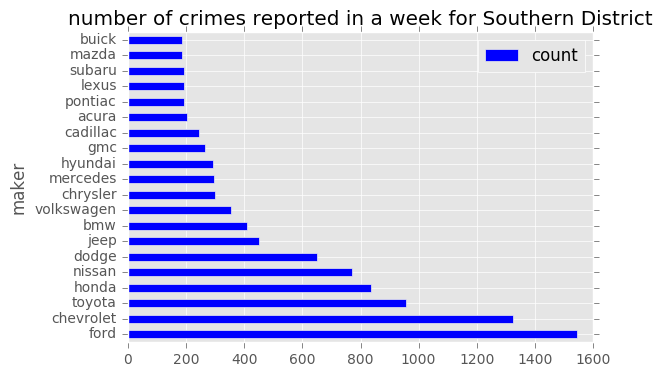

In [348]:
selected_table = pd.read_sql_query(sql_query,conn)
selected_table.plot.barh(x=selected_table.maker, color='blue', title="number of crimes reported in a week for Southern District")

So, the top three car model sell on the website, in descending order, are ford, chevrolet and toyota. 

Now, let's try to use wordcloud to visualize it. First, read in all the car maker from the sqlite object. 

In [499]:
sql_query = """
SELECT maker
FROM vehicle
where maker != 'NA';
"""
selected_table = pd.read_sql_query(sql_query,conn)

Next, we will load all the modules we need. 

In [507]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

Then, we will calculate the frequency of each car models appear in the data. 

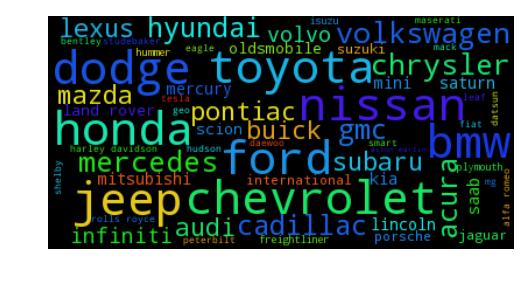

In [508]:
tuples = tuple([tuple(x) for x in selected_table.maker.value_counts().reset_index().values])
wordcloud = WordCloud(max_font_size=40).generate_from_frequencies(tuples)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

So, we can see the most common car models are from chevrolet, honda, ford, jeep and toyota. 

*** What are the most common words appear in title of the post and the body of the post? Are they the same? ***

In [554]:
# First take out the data we need, the title and body of the posts 

sql_query = """
SELECT title, body
FROM vehicle;
"""
selected_table = pd.read_sql_query(sql_query,conn)
selected_table.head()

title  \
0  2012 Chevrolet Camaro SS - All Credit Accepted...   
1  2013 Chevrolet Equinox LT - All Credit Accepte...   
2  2013 Nissan Altima 2.5 SV - All Credit Accepte...   
3  2009 Infiniti M35x X - All Credit Accepted - $...   
4  2013 Infiniti G37x X - All Credit Accepted - $...   

                                                body  
0  2012 Chevrolet Camaro SS\nOffered by: Automax ...  
1  2013 Chevrolet Equinox LT\nOffered by: Automax...  
2  2013 Nissan Altima 2.5 SV\nOffered by: Automax...  
3  2009 Infiniti M35x X\nOffered by: Automax Preo...  
4  2013 Infiniti G37x X\nOffered by: Automax Preo...

In [555]:
title = selected_table.title
body = selected_table.body

Next, we will take out the title, draw the word cloud and inspectt he most common words. 

In [548]:
title_list = [x.encode("ascii","ignore").split(' ') for x in title] # split each word
title_list = reduce(lambda x, y: x+y, title_list, []) # unlist
title_df = pd.DataFrame(title_list) # make it as dataframe
title_df.columns = ['title'] # give it back a column name

The wordcloud of the title of the post is given below. 

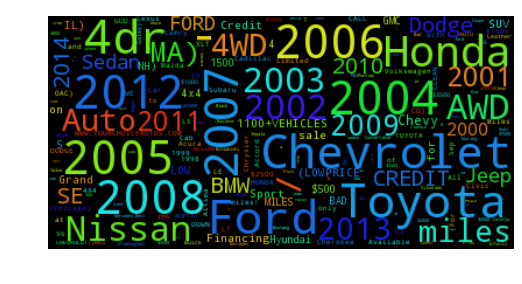

In [553]:
tuples = tuple([tuple(x) for x in title_df.title.value_counts().reset_index().values])
wordcloud = WordCloud(max_font_size=40).generate_from_frequencies(tuples)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

IT seems that the most common words on title are all about year or car model. 

Now, let's check the most common words on body. 

In [556]:
body_list = [x.encode("ascii","ignore").split(' ') for x in body] # split each word
body_list = reduce(lambda x, y: x+y, body_list, []) # unlist
body_df = pd.DataFrame(body_list) # make it as dataframe
body_df.columns = ['body'] # give it back a column name

The wordcloud for the body of the post is given below. 

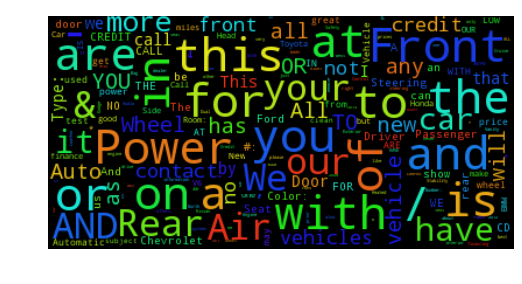

In [557]:
tuples = tuple([tuple(x) for x in body_df.body.value_counts().reset_index().values])
wordcloud = WordCloud(max_font_size=40).generate_from_frequencies(tuples)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Obviously, we dont see that years or car models names mentioned a lot here. So, the common words used in title are different from the common words used in body. 

## *** Summary ***

The vehicles sell posts informatoin are obtained from craiglist. Since they do not have API option. So, we have to scrape the posts on craiglist to get the car sell posts. At the end, it takes too much time to clean the data. Therefore, we use another dataset which is provided by Duncan in one of his STA141 classes. The car posts are mainly made by dealers. In general, the age of the car sell on the website by owner is older than the age of the car sell on the website by dealer. The scatterplot of car's age and odometer show that most odometers are less than 300000. Besides, few cars are selling for a huge amount. Most of the cars sell on the website are made by ford, toyota, chevrolet, honda and jeep. From the interactive plot, we can see most posts are coming from boston, denver and chicago. The ballon in the interactive also tell us a lot of posts are made from the samee dealers in the local areas. All in all, the words mentioned the most on the title of the post are different from the words mentioned the most on the body of the post.